In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    f1_score,
    make_scorer,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
feat_30_loc = "../data/features_30_sec.csv"
feat_3_loc = "../data/features_3_sec.csv"
# named long and short to differentiate easier
long = pd.read_csv(feat_30_loc)
short = pd.read_csv(feat_3_loc)

long_og = long.copy()
short_og = short.copy()

<IPython.core.display.Javascript object>

In [5]:
# log transform the mfcc variance
cc_var_cols = [f"mfcc{x}_var" for x in range(1, 21)]
logged_cc_var_long_df = long.copy()
logged_cc_var_short_df = short.copy()
for col in cc_var_cols:
    logged_cc_var_long_df[col + "_logged"] = np.log(logged_cc_var_long_df[col])
    logged_cc_var_long_df = logged_cc_var_long_df.drop(col, 1)
    logged_cc_var_short_df[col + "_logged"] = np.log(logged_cc_var_short_df[col])
    logged_cc_var_short_df = logged_cc_var_short_df.drop(col, 1)

<IPython.core.display.Javascript object>

In [6]:
m_start = 12  # highest mfcc to use. higher than this is too high in the frequency spectrum to really matter
mel_freq_drops = [f"mfcc{x}_mean" for x in range(m_start, 21)] + [
    f"mfcc{x}_var_logged" for x in range(m_start, 21)
]

<IPython.core.display.Javascript object>

In [7]:
long_X = logged_cc_var_long_df.drop("label", 1)
long_y = logged_cc_var_long_df["label"]

long_X_train, long_X_test, long_y_train, long_y_test = train_test_split(
    long_X, long_y, test_size=0.2, random_state=34, stratify=long_y
)

<IPython.core.display.Javascript object>

In [8]:
files_stripped = long_X_train["filename"].str.strip(".wav")
short_train_df = logged_cc_var_short_df[
    logged_cc_var_short_df["filename"].str.slice(0, -6).isin(list(files_stripped))
]
short_train_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc11_var_logged,mfcc12_var_logged,mfcc13_var_logged,mfcc14_var_logged,mfcc15_var_logged,mfcc16_var_logged,mfcc17_var_logged,mfcc18_var_logged,mfcc19_var_logged,mfcc20_var_logged
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,4.199753,3.808962,3.531333,3.876799,3.755859,3.681027,3.596990,3.640192,3.515064,3.778989
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,3.995884,3.705316,3.427791,3.887407,4.228071,4.170507,3.705679,3.936991,4.575029,4.093395
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,3.869358,3.599226,3.706844,3.423834,3.918273,4.209703,3.344577,3.822484,3.971251,3.499688
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,4.069718,3.666174,4.106187,3.699115,3.799220,3.865758,3.344173,3.548782,3.928609,3.466476
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,4.007883,3.766533,3.839780,3.217123,3.684292,3.412347,3.826049,3.938929,3.286115,3.372341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,rock.00098.5.wav,66149,0.423990,0.077954,0.105415,0.000510,1603.248807,107746.030923,1832.425252,60935.805862,...,3.695100,3.619010,3.516421,3.100012,3.826093,3.883990,3.567032,3.426182,3.394696,3.360307
9976,rock.00098.6.wav,66149,0.365676,0.083008,0.109754,0.000337,1522.404166,101192.686629,1799.056171,50667.610606,...,3.498222,3.638079,3.209702,3.761270,3.783397,3.759324,3.771833,3.663633,2.980535,3.562415
9977,rock.00098.7.wav,66149,0.328398,0.096012,0.056352,0.001678,1382.797488,273554.352363,1811.470996,124882.681401,...,4.057362,4.974400,4.457256,3.593842,4.188851,4.331148,3.875327,3.697891,3.690622,4.037018
9978,rock.00098.8.wav,66149,0.254980,0.104420,0.018005,0.000386,1003.694252,245870.031401,1581.533448,113937.339221,...,3.747703,4.004866,3.609216,3.817424,3.675378,3.659123,2.780470,3.795206,3.364819,3.147167


<IPython.core.display.Javascript object>

In [9]:
files_stripped = long_X_test["filename"].str.strip(".wav")
short_test_df = logged_cc_var_short_df[
    logged_cc_var_short_df["filename"].str.slice(0, -6).isin(list(files_stripped))
]
short_test_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc11_var_logged,mfcc12_var_logged,mfcc13_var_logged,mfcc14_var_logged,mfcc15_var_logged,mfcc16_var_logged,mfcc17_var_logged,mfcc18_var_logged,mfcc19_var_logged,mfcc20_var_logged
50,blues.00005.0.wav,66149,0.302958,0.089490,0.074403,0.001349,1148.336755,1.170769e+05,1481.481546,143128.714704,...,3.129887,4.317805,3.868644,3.198746,3.220440,3.638702,2.955164,3.163215,3.462902,3.156687
51,blues.00005.1.wav,66149,0.325506,0.081894,0.080293,0.000953,1210.571572,1.131322e+05,1424.920044,94457.446495,...,3.874508,3.669179,3.952440,3.325389,2.593266,3.462044,3.741462,3.500137,2.721179,3.418986
52,blues.00005.2.wav,66149,0.299864,0.094797,0.156715,0.007108,3191.200301,9.938051e+05,2190.240135,139259.541216,...,4.811318,4.949066,4.504757,4.642990,5.082304,4.432605,4.186323,4.351435,3.565979,4.315627
53,blues.00005.3.wav,66149,0.299961,0.088112,0.124830,0.003337,2124.493966,1.523189e+06,1771.906237,192267.549549,...,3.871562,4.349438,4.354326,3.760185,4.023502,4.525363,4.240223,4.191362,3.508737,3.779347
54,blues.00005.4.wav,66149,0.323245,0.100346,0.073035,0.004465,2446.168018,1.378259e+06,2092.543627,105147.949580,...,5.086935,4.709287,4.623443,3.945663,5.041515,4.050801,4.139557,3.832766,3.993757,3.859010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,1.642669e+05,1718.707215,85931.574523,...,3.416803,3.839206,3.935643,3.410298,4.386414,3.749174,3.646150,3.435594,3.887814,3.662714
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,2.810549e+05,1906.468492,99727.037054,...,3.501858,3.690007,3.688708,3.818595,3.533665,3.478628,4.195977,3.996626,4.150288,2.928365
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,6.629562e+05,1561.859087,138762.841945,...,4.520072,3.518154,3.361223,4.594477,3.787080,4.359630,3.080946,3.257359,3.883261,3.727787
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,2.038910e+05,2018.366254,22860.992562,...,3.353508,3.200891,2.922559,2.939444,3.026968,3.343700,2.845487,3.065395,3.212601,2.548488


<IPython.core.display.Javascript object>

In [10]:
# best balance for VIF I could tune
drop_cols = [
    "length",
    "filename",
    "label",
    #     "zero_crossing_rate_mean",
    #     "zero_crossing_rate_var",
    "rolloff_mean",
    "harmony_var",
    "rolloff_var",
    "spectral_centroid_var",
    "spectral_bandwidth_var",
    "spectral_centroid_mean",
    "spectral_bandwidth_mean",
    #     "rms_mean",
    #     "rms_var",
]
drop_cols = drop_cols + mel_freq_drops
print_vif(logged_cc_var_short_df.drop(drop_cols, 1,))

VIF results
-------------------------------
const                      776.274686
chroma_stft_mean             3.391661
chroma_stft_var              2.546500
rms_mean                     7.666024
rms_var                      3.268666
zero_crossing_rate_mean      6.949903
zero_crossing_rate_var       2.660002
harmony_mean                 1.478593
perceptr_mean                1.573693
perceptr_var                 4.918247
tempo                        1.009578
mfcc1_mean                   7.258845
mfcc2_mean                   5.652443
mfcc3_mean                   2.547365
mfcc4_mean                   2.076686
mfcc5_mean                   2.679961
mfcc6_mean                   3.340509
mfcc7_mean                   3.014978
mfcc8_mean                   3.704902
mfcc9_mean                   2.584736
mfcc10_mean                  2.548987
mfcc11_mean                  2.098440
mfcc1_var_logged             2.949586
mfcc2_var_logged             2.583133
mfcc3_var_logged             2.590872
mfcc4_

<IPython.core.display.Javascript object>

In [11]:
X_train = short_train_df.drop(drop_cols, 1)
X_test = short_test_df.drop(drop_cols, 1)
y_train = short_train_df["label"]
y_test = short_test_df["label"]

<IPython.core.display.Javascript object>

In [12]:
num_cols = list(X_train.columns)

bin_cols = []

cat_cols = []
drop_cats = []


preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        # Choose your model and put it here
        ("xgb", XGBClassifier()),
    ]
)


params = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "xgb__max_depth": [3, 5],
}

n_trees = 100
learning_rate = 10 / n_trees

pipeline["xgb"].n_estimators = n_trees
pipeline["xgb"].learning_rate = learning_rate

scaler = pipeline.named_steps["preprocessing"]
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)


pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

pipeline_cv.fit(X_train, y=y_train, xgb__eval_set=[(X_test_scaled, y_test)])


print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))
pipeline_cv.best_params_

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


[0]	validation_0-merror:0.52350
[1]	validation_0-merror:0.46300
[2]	validation_0-merror:0.44100


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.1min finished


[3]	validation_0-merror:0.41500
[4]	validation_0-merror:0.39700
[5]	validation_0-merror:0.39350
[6]	validation_0-merror:0.38850
[7]	validation_0-merror:0.37850
[8]	validation_0-merror:0.37100
[9]	validation_0-merror:0.36150
[10]	validation_0-merror:0.35900
[11]	validation_0-merror:0.36150
[12]	validation_0-merror:0.35600
[13]	validation_0-merror:0.35350
[14]	validation_0-merror:0.34750
[15]	validation_0-merror:0.34150
[16]	validation_0-merror:0.34300
[17]	validation_0-merror:0.34150
[18]	validation_0-merror:0.34350
[19]	validation_0-merror:0.34050
[20]	validation_0-merror:0.34200
[21]	validation_0-merror:0.33850
[22]	validation_0-merror:0.33800
[23]	validation_0-merror:0.33800
[24]	validation_0-merror:0.33750
[25]	validation_0-merror:0.33350
[26]	validation_0-merror:0.33700
[27]	validation_0-merror:0.33750
[28]	validation_0-merror:0.33600
[29]	validation_0-merror:0.33350
[30]	validation_0-merror:0.33450
[31]	validation_0-merror:0.33350
[32]	validation_0-merror:0.33250
[33]	validation_0

{'xgb__colsample_bytree': 0.4, 'xgb__max_depth': 5, 'xgb__subsample': 0.75}

<IPython.core.display.Javascript object>

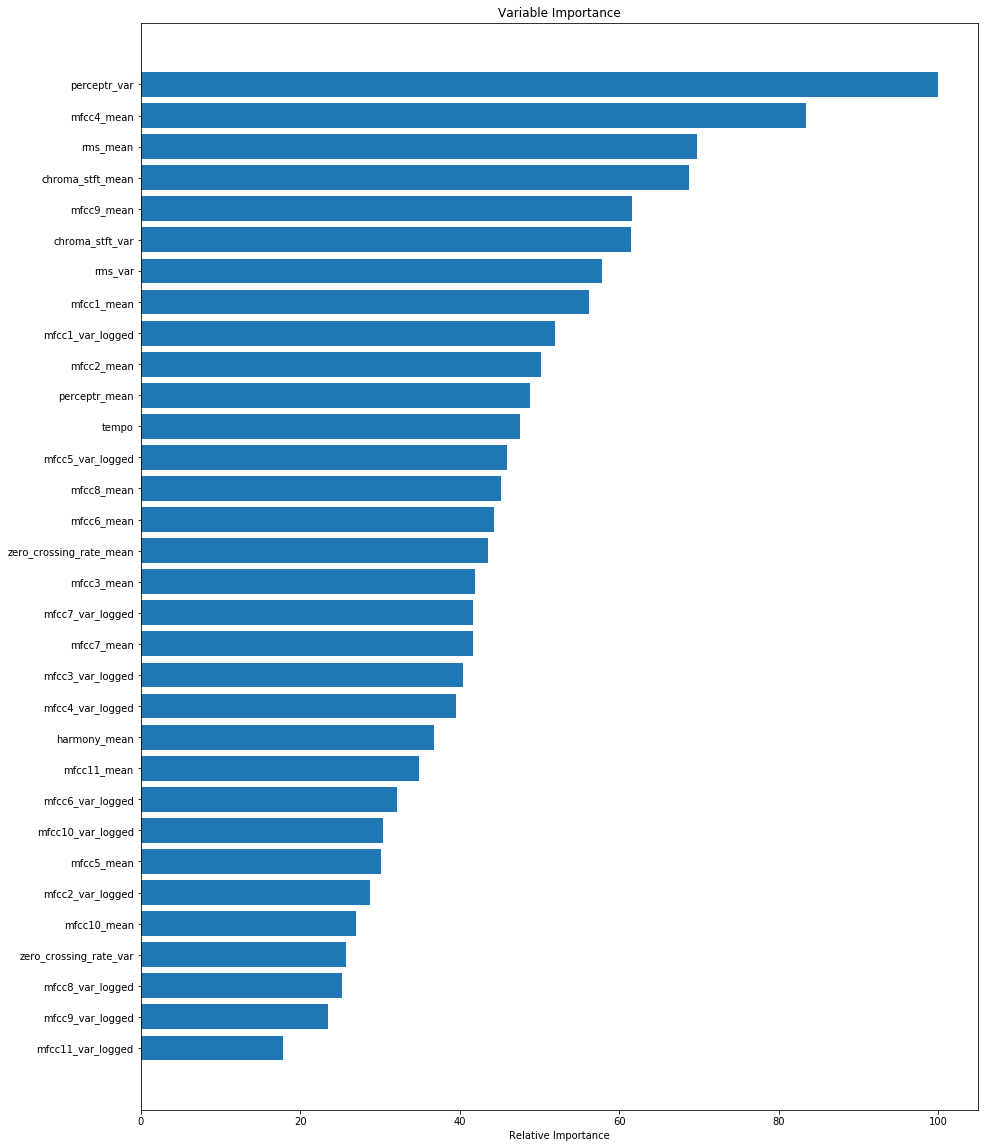

<IPython.core.display.Javascript object>

In [28]:
feature_importance = pipeline_cv.best_estimator_.named_steps["xgb"].feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5


plt.figure(figsize=(15, 20))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [29]:
y_pred = pipeline_cv.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[146   0  18   1   0  12   8   0  13   2]
 [  0 192   0   0   0   8   0   0   0   0]
 [ 11   0 143   8   0  10  10   1   8   9]
 [  2   0  13 149  11   1   0  16   6   2]
 [  1   0   5  24 107   0  11  28  18   6]
 [  0  30  21   1   0 135   0   4   1   8]
 [  5   0   0   8   6   0 172   0   0   9]
 [  0   0  10   2   1   3   0 161   9  14]
 [  6   0  31  15   9   1   8   2 123   5]
 [  3   3  29  26   5  19  17  12   8  78]]
              precision    recall  f1-score   support

       blues       0.84      0.73      0.78       200
   classical       0.85      0.96      0.90       200
     country       0.53      0.71      0.61       200
       disco       0.64      0.74      0.69       200
      hiphop       0.77      0.54      0.63       200
        jazz       0.71      0.68      0.69       200
       metal       0.76      0.86      0.81       200
         pop       0.72      0.81      0.76       200
      reggae       0.66      0.61      0.64       200
        rock       0.59     

<IPython.core.display.Javascript object>

In [30]:
short["predicted"] = pipeline_cv.predict(logged_cc_var_short_df.drop(drop_cols, 1))

<IPython.core.display.Javascript object>

In [31]:
long["vote_pred"] = "none"

for i in range(long["filename"].size):
    curr_file = long["filename"][i]
    file_stripped = curr_file.strip(".wav")
    sub_selection = short["filename"].str.contains(file_stripped)
    prediction = (
        short[sub_selection]["predicted"]
        .value_counts()
        .sort_values(ascending=False)
        .index[0]
    )
    long["vote_pred"][i] = prediction

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


<IPython.core.display.Javascript object>

In [32]:
print(confusion_matrix(long["label"], long["vote_pred"]))
print(classification_report(long["label"], long["vote_pred"]))

[[96  0  0  0  0  2  1  0  1  0]
 [ 0 99  0  0  0  1  0  0  0  0]
 [ 0  0 96  1  0  1  1  0  1  0]
 [ 0  0  1 96  2  0  0  1  0  0]
 [ 0  0  0  2 92  0  2  3  0  1]
 [ 0  2  1  0  0 96  0  0  0  1]
 [ 0  0  0  1  0  0 98  0  0  1]
 [ 0  0  1  0  0  0  0 96  1  2]
 [ 0  0  3  1  1  0  1  0 94  0]
 [ 0  0  3  4  1  2  2  2  1 85]]
              precision    recall  f1-score   support

       blues       1.00      0.96      0.98       100
   classical       0.98      0.99      0.99       100
     country       0.91      0.96      0.94       100
       disco       0.91      0.96      0.94       100
      hiphop       0.96      0.92      0.94       100
        jazz       0.94      0.96      0.95       100
       metal       0.93      0.98      0.96       100
         pop       0.94      0.96      0.95       100
      reggae       0.96      0.94      0.95       100
        rock       0.94      0.85      0.89       100

    accuracy                           0.95      1000
   macro avg       

<IPython.core.display.Javascript object>

In [34]:
long_pred_df = logged_cc_var_long_df.drop(drop_cols, 1)
# long_pred_df = scaler.transform(long_pred_df)
long["model_pred"] = pipeline_cv.predict(long_pred_df)

<IPython.core.display.Javascript object>

In [35]:
print(confusion_matrix(long["label"], long["model_pred"]))
print(classification_report(long["label"], long["model_pred"]))

[[90  0  2  2  0  0  0  0  5  1]
 [ 0 93  1  0  0  5  0  0  1  0]
 [ 3  0 90  1  0  0  1  0  5  0]
 [ 0  0  1 93  3  0  0  1  2  0]
 [ 0  0  2  3 88  0  0  3  4  0]
 [ 0  2  8  0  0 87  0  0  3  0]
 [ 4  0  0  1  0  0 92  0  1  2]
 [ 0  0  1  1  1  0  0 94  2  1]
 [ 0  0  3  2  1  0  0  1 93  0]
 [ 3  0 10  7  1  0  2  1  4 72]]
              precision    recall  f1-score   support

       blues       0.90      0.90      0.90       100
   classical       0.98      0.93      0.95       100
     country       0.76      0.90      0.83       100
       disco       0.85      0.93      0.89       100
      hiphop       0.94      0.88      0.91       100
        jazz       0.95      0.87      0.91       100
       metal       0.97      0.92      0.94       100
         pop       0.94      0.94      0.94       100
      reggae       0.78      0.93      0.85       100
        rock       0.95      0.72      0.82       100

    accuracy                           0.89      1000
   macro avg       

<IPython.core.display.Javascript object>

In [36]:
drop_cols_copy = drop_cols.copy()
drop_cols_copy.remove("label")
long_y_pred = pipeline_cv.predict(long_X_test.drop(drop_cols_copy, 1))

<IPython.core.display.Javascript object>

In [37]:
# model prediction on original train test split on the long df training
pipeline_cv.score(long_X_train.drop(drop_cols_copy, 1), long_y_train)

0.93125

<IPython.core.display.Javascript object>

In [38]:
# model prediction on original train test split on the long df testing
pipeline_cv.score(long_X_test.drop(drop_cols_copy, 1), long_y_test)

0.735

<IPython.core.display.Javascript object>

In [39]:
long_y_pred
print(confusion_matrix(long_y_test, long_y_pred))
print(classification_report(long_y_test, long_y_pred))

[[16  0  1  0  0  0  0  0  3  0]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 0  0 18  1  0  0  1  0  0  0]
 [ 0  0  1 15  2  0  0  1  1  0]
 [ 0  0  1  3 10  0  0  3  3  0]
 [ 0  2  4  0  0 13  0  0  1  0]
 [ 1  0  0  1  0  0 17  0  0  1]
 [ 0  0  1  1  0  0  0 16  1  1]
 [ 0  0  3  2  0  0  0  0 15  0]
 [ 0  0  4  3  1  0  2  1  1  8]]
              precision    recall  f1-score   support

       blues       0.94      0.80      0.86        20
   classical       0.90      0.95      0.93        20
     country       0.55      0.90      0.68        20
       disco       0.58      0.75      0.65        20
      hiphop       0.77      0.50      0.61        20
        jazz       0.93      0.65      0.76        20
       metal       0.85      0.85      0.85        20
         pop       0.76      0.80      0.78        20
      reggae       0.60      0.75      0.67        20
        rock       0.80      0.40      0.53        20

    accuracy                           0.73       200
   macro avg       

<IPython.core.display.Javascript object>

In [40]:
long_vote_pred = long["vote_pred"]
long_label = long["label"]

(
    long_vote_pred_train,
    long_vote_pred_test,
    long_label_train,
    long_label_test,
) = train_test_split(
    long_vote_pred, long_label, test_size=0.2, random_state=34, stratify=long_label
)

<IPython.core.display.Javascript object>

In [41]:
print(confusion_matrix(long_label_test, long_vote_pred_test))
print(classification_report(long_label_test, long_vote_pred_test))

[[16  0  0  0  0  2  1  0  1  0]
 [ 0 19  0  0  0  1  0  0  0  0]
 [ 0  0 16  1  0  1  1  0  1  0]
 [ 0  0  1 16  2  0  0  1  0  0]
 [ 0  0  0  2 12  0  2  3  0  1]
 [ 0  2  1  0  0 16  0  0  0  1]
 [ 0  0  0  1  0  0 18  0  0  1]
 [ 0  0  1  0  0  0  0 16  1  2]
 [ 0  0  3  1  1  0  1  0 14  0]
 [ 0  0  3  2  1  2  2  2  1  7]]
              precision    recall  f1-score   support

       blues       1.00      0.80      0.89        20
   classical       0.90      0.95      0.93        20
     country       0.64      0.80      0.71        20
       disco       0.70      0.80      0.74        20
      hiphop       0.75      0.60      0.67        20
        jazz       0.73      0.80      0.76        20
       metal       0.72      0.90      0.80        20
         pop       0.73      0.80      0.76        20
      reggae       0.78      0.70      0.74        20
        rock       0.58      0.35      0.44        20

    accuracy                           0.75       200
   macro avg       

<IPython.core.display.Javascript object>

In [42]:
print(confusion_matrix(long_label_train, long_vote_pred_train))
print(classification_report(long_label_train, long_vote_pred_train))

[[80  0  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0  0]
 [ 0  0  0 80  0  0  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0  0 80  0]
 [ 0  0  0  2  0  0  0  0  0 78]]
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00        80
   classical       1.00      1.00      1.00        80
     country       1.00      1.00      1.00        80
       disco       0.98      1.00      0.99        80
      hiphop       1.00      1.00      1.00        80
        jazz       1.00      1.00      1.00        80
       metal       1.00      1.00      1.00        80
         pop       1.00      1.00      1.00        80
      reggae       1.00      1.00      1.00        80
        rock       1.00      0.97      0.99        80

    accuracy                           1.00       800
   macro avg       

<IPython.core.display.Javascript object>